In [1]:
import numpy as np
import random as rnd
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from braniac.readers.body import SequenceBodyReader
from braniac.viz import Skeleton2D
from braniac.format import SourceFactory
from visualize_skeleton import draw_to_file
from utils import gradient_penalty

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
    
    def forward(self, input_seq):
        output, hidden = self.gru(input_seq)
        # Prendi solo l'ultimo hidden state dell'ultimo layer
        output = output[:, -1, :]
        return output, hidden

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.linear_hidden = nn.Linear(2*hidden_size, output_size)
        self.linear_out = nn.Linear(hidden_size, output_size)
        self.gru1 = nn.GRUCell(output_size , output_size)
        self.gru2 = nn.GRUCell(output_size, output_size)
        
    
    def forward(self, x, hidden , z):
        hidden_1 = torch.cat([hidden[0,:], z], dim=1)
        hidden_2 = torch.cat([hidden[1,:], z], dim=1)
        hidden_1 = self.linear_hidden(hidden_1)
        hidden_2 = self.linear_hidden(hidden_2)
        out = self.linear_out(x)
        decoded_sequence = []
        for i in range(20):
            hidden_1 = self.gru1(out, hidden_1)
            hidden_2 = self.gru2(hidden_1, hidden_2)
            out = hidden_2
            decoded_sequence.append(out)
        
        decoded_sequence = torch.stack(decoded_sequence, dim=1)
        return decoded_sequence

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(hidden_size, output_size)
    def forward(self, input_seq, z):
        output, hidden = self.encoder(input_seq)
        decoded_sequence = self.decoder(output, hidden, z)
        return decoded_sequence

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = nn.functional.leaky_relu(self.fc1(x))
        x = nn.functional.leaky_relu(self.fc2(x))
        out = nn.functional.sigmoid(self.fc3(x))
        return out

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = nn.functional.leaky_relu(self.fc1(x))
        x = nn.functional.leaky_relu(self.fc2(x))
        out = self.fc3(x)
        return out

In [4]:
max_epochs = 1000
dataset = "nturgbd"

# input and output information
input_sequence_length = 10
output_sequence_length = 20
sequence_length = input_sequence_length + output_sequence_length
input_size = 75
input_discriminator_size = 2250
hidden_size = 128
output_size = 75
num_layers = 2
z_size = 128 # Latent value that control predicted poses.
data_preprocessing = None
LAMBDA_GP = 10
CRITIC_ITERATIONS = 10

source = SourceFactory(dataset, "cameras.h5")
sensor = source.create_sensor()
body_inf = source.create_body()
skeleton2D = Skeleton2D(sensor, body_inf)


train_data_reader = SequenceBodyReader('splitted_skeleton\\train_map.csv', sequence_length, dataset,skip_frame=0,data_preprocessing=data_preprocessing,random_sequence=False)
# setting up the model
minibatch_size = 16
lr_init = 5e-5

d_lr = lr_init
g_lr = lr_init    
epoch = 0

lossGenerator = []
lossCritic = []
lossDiscriminator = []

z_rand_params = {'low':-0.1, 'high':0.1}
def generate_random(params, shape):
    return np.random.uniform(params['low'], params['high'], size=shape)

generator = Generator(input_size, hidden_size, output_size)
discriminator = Discriminator(input_discriminator_size, hidden_size)
critic = Critic(input_discriminator_size, hidden_size)

opt_disc = optim.Adam(discriminator.parameters(), lr=d_lr)
opt_gen = optim.Adam(generator.parameters(), lr=g_lr)
opt_critic = optim.Adam(critic.parameters(), lr=d_lr)
criterion = nn.BCELoss()
criterion_regr = nn.MSELoss()


In [5]:
output_folder ="skeleton_images"
def print_skeletons(real_poses, fake_poses, epoch):
    real_poses = real_poses.view(12, 30, 25, 3)
    real_poses = np.array(real_poses.detach().numpy())
    fake_poses = fake_poses.view(12, 30, 25, 3)
    fake_poses = np.array(fake_poses.detach().numpy())
    skeleton2D.draw_to_file(real_poses, 0, os.path.join(output_folder, "real_poses_{}.png".format(epoch)))
    skeleton2D.draw_to_file(fake_poses, 0, os.path.join(output_folder, "fake_poses_{}.png".format(epoch)))

In [6]:
for epoch in range(max_epochs):
    train_data_reader.reset()
    idx = 0
    while(train_data_reader.has_more()):
     #inizializzo pose
     input_data, _, current_batch_size, _, _ = train_data_reader.next_minibatch(minibatch_size)
     #input_data = input_data / np.linalg.norm(input_data)
     real_poses = torch.from_numpy(input_data)
     #input_data = input_data.reshape(-1, sequence_length, input_size)
     prior_poses = real_poses[:, :10, :, :] 
     future_poses = real_poses[:, 10:, :, :]    
     
     #genero rumore
     z_data = generate_random(z_rand_params, shape=[current_batch_size, z_size])
     z_data = torch.from_numpy(z_data).float() 
     

     #real_poses = real_poses.view(real_poses.shape[0], -1)
     #fake_poses = fake_poses.view(fake_poses.shape[0], -1)
     #real_poses.requires_grad_(True)
     #fake_poses.requires_grad_(True)

     #Train critic
     for _ in range(CRITIC_ITERATIONS):
        #genero pose
        fake_poses = generator(prior_poses.view(prior_poses.shape[0], prior_poses.shape[1], -1), z_data)
        fake_poses = fake_poses.view(fake_poses.shape[0], 20, 25, 3)
        fake_poses_generated = fake_poses
        fake_poses = torch.cat((prior_poses, fake_poses), axis=1)
        critic_real = critic(real_poses.view(real_poses.shape[0], -1)).view(-1) 
        critic_fake = critic(fake_poses.view(fake_poses.shape[0], -1)).view(-1)
        gp = gradient_penalty(critic, real_poses, fake_poses)
        lossC = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP*gp)
        critic.zero_grad()
        lossC.backward(retain_graph=True)
        opt_critic.step() 

    


    #Train discriminator
     disc_real = discriminator(real_poses.view(real_poses.shape[0], -1))
     lossD_real = criterion(disc_real, torch.ones_like(disc_real))
     disc_fake = discriminator(fake_poses.view(fake_poses.shape[0], -1)).view(-1)
     lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
     lossD = (lossD_real + lossD_fake) / 2
     discriminator.zero_grad()
     lossD.backward(retain_graph=True)
     opt_disc.step()

    #Train generator
     output = critic(fake_poses.view(fake_poses.shape[0], -1)).view(-1)
     loss_ground_truth = criterion_regr(fake_poses_generated, future_poses)
     lossG = -torch.mean(output) + loss_ground_truth
     generator.zero_grad()
     lossG.backward(retain_graph=True)
     opt_gen.step()

     
       
    lossGenerator.append(lossG.item())
    lossCritic.append(lossC.item())
    lossDiscriminator.append(lossD.item())

    

    print(f"Epoch [{epoch}/{max_epochs}] LossC: {lossC:.4f} lossD: {lossD:.4f} loss G: {lossG:.4f}")
    if(epoch > 300):
        print_skeletons(real_poses, fake_poses, epoch)

Epoch [0/1000] LossC: -13.3829 lossD: 0.2801 loss G: 7.7508
Epoch [1/1000] LossC: -67.6240 lossD: 0.1206 loss G: 18.7989
Epoch [2/1000] LossC: -147.7998 lossD: 0.0578 loss G: 36.7350
Epoch [3/1000] LossC: -202.3028 lossD: 0.0289 loss G: 43.0473
Epoch [4/1000] LossC: -212.7237 lossD: 0.0167 loss G: 6.9659
Epoch [5/1000] LossC: -195.9164 lossD: 0.0108 loss G: -27.0513
Epoch [6/1000] LossC: -179.6648 lossD: 0.0072 loss G: -44.9268
Epoch [7/1000] LossC: -167.1325 lossD: 0.0049 loss G: -53.4388
Epoch [8/1000] LossC: -156.8912 lossD: 0.0037 loss G: -59.4730
Epoch [9/1000] LossC: -147.5345 lossD: 0.0030 loss G: -64.7394
Epoch [10/1000] LossC: -137.8884 lossD: 0.0026 loss G: -69.4991
Epoch [11/1000] LossC: -126.7871 lossD: 0.0024 loss G: -73.8614
Epoch [12/1000] LossC: -113.7464 lossD: 0.0023 loss G: -77.3324
Epoch [13/1000] LossC: -99.1386 lossD: 0.0023 loss G: -79.1028
Epoch [14/1000] LossC: -84.8867 lossD: 0.0024 loss G: -78.7845
Epoch [15/1000] LossC: -72.4608 lossD: 0.0027 loss G: -77.832

KeyboardInterrupt: 

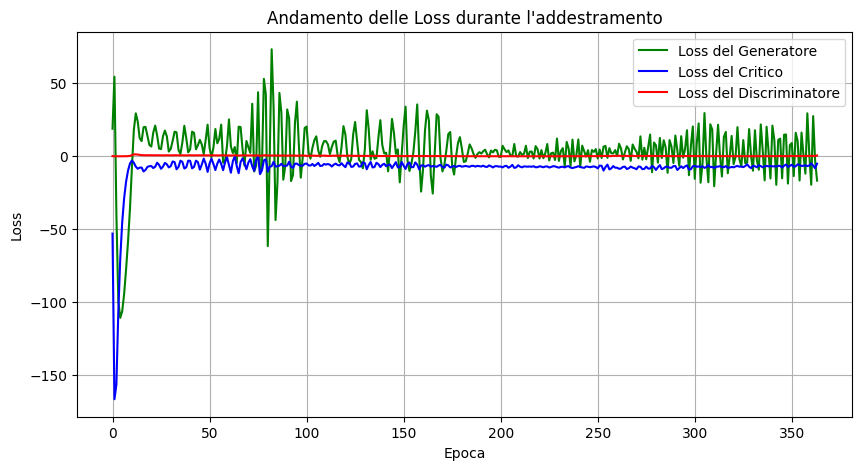

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(lossGenerator, label='Loss del Generatore', linestyle='-', color='green')
plt.plot(lossCritic, label='Loss del Critico', linestyle='-', color='blue')
plt.plot(lossDiscriminator, label='Loss del Discriminatore', linestyle='-', color='red')

# Personalizzazione del grafico
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Andamento delle Loss durante l\'addestramento')
plt.legend()

# Visualizzazione del grafico
plt.grid()
plt.show()